## Install Sentence Transformers

- q : Quiet installation (no output)
- U : Update if already installed

In [1]:
!pip install -qU sentence-transformers

## Import packages

- pandas : to work with tables
- json : to work  with JSON files (tweet timeline data)
- datetime : to work with dates (process tweet timestamps)
- math : to make formulas
- tqdm : for progress bars
- seaborn : plotting
- matplotlib : plotting
- sentence_transformers : embedding model
- sklearn : pairwise metrics

In [2]:
import pandas as pd
import json
from datetime import datetime
from datetime import timedelta
import math
from tqdm.auto import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer, util
from sklearn.metrics.pairwise import *

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Read the user data

- contains the data of 1111 users
- contains duplicate users as well
- columns : `['id', 'id_str', 'name', 'screen_name', 'location', 'description', 'url', 'entities', 'protected', 'followers_count', 'friends_count', 'listed_count', 'created_at', 'favourites_count', 'utc_offset', 'time_zone', 'geo_enabled', 'verified', 'statuses_count', 'lang', 'status', 'contributors_enabled', 'is_translator', 'is_translation_enabled', 'profile_background_color', 'profile_background_image_url', 'profile_background_image_url_https', 'profile_background_tile', 'profile_image_url', 'profile_image_url_https', 'profile_link_color', 'profile_sidebar_border_color', 'profile_sidebar_fill_color', 'profile_text_color', 'profile_use_background_image', 'has_extended_profile', 'default_profile', 'default_profile_image', 'following', 'live_following', 'follow_request_sent', 'notifications', 'muting', 'blocking', 'blocked_by', 'translator_type', 'withheld_in_countries', 'profile_banner_url', 'Parent', 'profile_location']`

In [3]:
user_data = pd.read_csv('/kaggle/input/twitter-timeline-data/user_data.csv')
user_data

,id,id_str,name,screen_name,location,description,url,entities,protected,followers_count,...,follow_request_sent,notifications,muting,blocking,blocked_by,translator_type,withheld_in_countries,profile_banner_url,Parent,profile_location
0,1745104415353348096,1745104415353348096,Ayush,fuxx_32678,NaN,NaN,NaN,{'description': {'urls': []}},False,0,...,False,False,False,False,False,none,[],NaN,RahulGandhi,NaN
1,1749375183641886720,1749375183641886720,Karen Cates,CatesKaren64505,NaN,NaN,NaN,{'description': {'urls': []}},False,0,...,False,False,False,False,False,none,[],NaN,RahulGandhi,NaN
2,1419544279500746758,1419544279500746758,Afijer Hossain,afijer_hossain,"Koch Bihar, India","SMILE to change the World, don't let the World...",https://t.co/jgaKGpkiw2,{'url': {'urls': [{'url': 'https://t.co/jgaKGp...,False,12,...,False,False,False,False,False,none,[],https://pbs.twimg.com/profile_banners/14195442...,RahulGandhi,NaN
3,1385666198570864641,1385666198570864641,Subham Mohanty,subhamohanty_jk,NaN,A little boy from India.🇮🇳,NaN,{'description': {'urls': []}},False,4,...,False,False,False,False,False,none,[],https://pbs.twimg.com/profile_banners/13856661...,RahulGandhi,NaN
4,1742842252320198656,1742842252320198656,Vienna Donovan,DonovanVie81310,"Charlotte, NC","Embodying the spirit of love's divine goddess,...",https://t.co/2GnrMsThRQ,{'url': {'urls': [{'url': 'https://t.co/2GnrMs...,False,19,...,False,False,False,False,False,none,[],https://pbs.twimg.com/profile_banners/17428422...,RahulGandhi,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1106,813286,813286,Barack Obama,BarackObama,"Washington, DC","Dad, husband, President, citizen.",https://t.co/9EAGxkEB9p,{'url': {'urls': [{'url': 'https://t.co/9EAGxk...,False,131901814,...,False,False,NaN,NaN,NaN,regular,[],https://pbs.twimg.com/profile_banners/813286/1...,NaN,NaN
1107,166739404,166739404,Emma Watson,EmmaWatson,NaN,NaN,https://t.co/bvMO5Qlo4Y,{'url': {'urls': [{'url': 'https://t.co/bvMO5Q...,False,27425522,...,False,False,NaN,NaN,NaN,none,[],https://pbs.twimg.com/profile_banners/16673940...,NaN,NaN
1108,62513246,62513246,J.K. Rowling,jk_rowling,Scotland,Writer sometimes known as Robert Galbraith,https://t.co/sQiPGyMaQ2,{'url': {'urls': [{'url': 'https://t.co/sQiPGy...,False,13988857,...,False,False,NaN,NaN,NaN,regular,[],https://pbs.twimg.com/profile_banners/62513246...,NaN,NaN
1109,26589987,26589987,Serena Williams,serenawilliams,Somewhere over the Rainbow,"Living, Loving, and working to help you.",https://t.co/dQQQA3ino7,{'url': {'urls': [{'url': 'https://t.co/dQQQA3...,False,10474306,...,False,False,NaN,NaN,NaN,none,[],https://pbs.twimg.com/profile_banners/26589987...,NaN,NaN


## Define the columns required for embedding generation (user)

In [4]:
user_columns = ['name','screen_name','location','description']
meta_data = ['followers_count','friends_count','created_at']

In [5]:
user_data_1 = user_data[user_columns]
meta_data = user_data[meta_data]

## Load tweet timeline data of users (json file)

structure:

```json
[
    [
        {<user_1_tweet_1>},
        {<user_1_tweet_2>},
        ...
    ],
    [
        {<user_2_tweet_1>},
        {<user_2_tweet_2>},
        ...
    ],
    ...
]
```

In [6]:
timeline_data = json.load(open('/kaggle/input/twitter-timeline-data/timelines/timelines.json'))

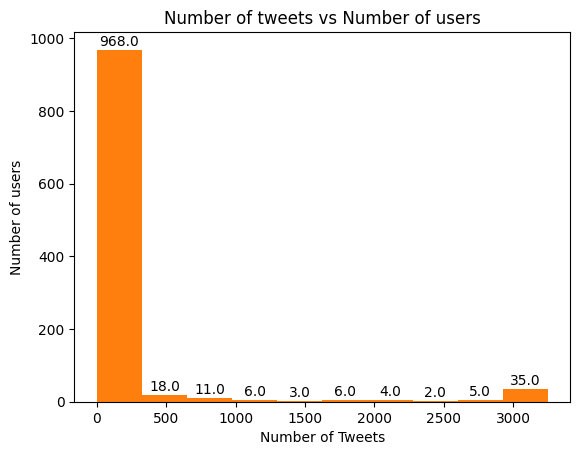

In [7]:
plt.hist([len(i) for i in timeline_data])

# Getting the bar heights and positions
n, bins, patches = plt.hist([len(i) for i in timeline_data])

# Selecting 6-7 bars for annotation
selected_patches = patches

# Annotating the selected bars
for patch in selected_patches:
    height = patch.get_height()
    xpos = patch.get_x() + patch.get_width() / 2
    plt.annotate(f'{height}', xy=(xpos, height), xytext=(0, 3), textcoords='offset points', ha='center')


# Displaying the plot
plt.xlabel('Number of Tweets')

# Adding y-axis label
plt.ylabel('Number of users')

# Adding title
plt.title('Number of tweets vs Number of users')

plt.show()


## Define the columns required for embedding generation (tweets)

In [8]:
tweet_columns = ['created_at','text','entities["hashtags","user_mentions"]','source','user["screen_name"]','place']


where:
- $\text{Weight}(i)$ is the weight assigned to the datetime object at index $i$.
- $e$ is the mathematical constant approximately equal to 2.71828.
- $\alpha$ is a decay constant that determines the rate of decay.
- $\text{days_difference}(i)$ is the number of days between the datetime object at index $i$ and the latest datetime object in the list.


In this example, the `exponential_decay_weights` function takes a list of datetime objects and a decay constant (\(\alpha\)) as input and returns a list of weights corresponding to each datetime object. The higher the decay constant, the faster the weights decrease with time. The formula used here assigns higher weights to more recent datetime objects and lower weights to older ones.

In LaTeX, the formula would be represented as:

$$\huge{{\text{Weight}}(i) = e^{-\alpha \cdot \text{{days_difference}}(i)}}$$

## Function to extract the timeline data of a given user as a dataframe

This code defines a Python function `get_timeline_data(screen_name)` that takes a Twitter screen name as input and extracts data from a timeline to create a DataFrame. Here are the main points explaining the code:

1. The function takes a single argument, `screen_name`, which represents the Twitter screen name of a user.

2. It initializes an empty list `t_data` to store the extracted data from the timeline.

3. `date_format` is defined as the format for parsing datetime strings from Twitter data.

4. The function iterates over `timeline_data`, presumably a list of Twitter timeline entries.

5. It checks if the length of the current timeline entry (`i`) is zero. If it is, the loop continues to the next entry, skipping the empty one.

6. Inside the loop, it checks if the screen name of the user who posted the current timeline entry matches the input `screen_name`. If it matches, it proceeds to extract data from this entry.

7. Within the inner loop (nested within the matching user condition), it extracts the following information from each tweet:
   - `created_at`: Parses the tweet's creation timestamp using the specified date format.
   - `text`: The text content of the tweet.
   - `hashtags`: Concatenates the hashtags mentioned in the tweet into a space-separated string.
   - `mentions`: Concatenates the screen names of user mentions in the tweet into a space-separated string.
   - `source`: Extracts the source of the tweet (likely the client or device used to post the tweet) by parsing it from HTML-like tags.
   - `place`: Retrieves information about the tweet's location, if available.

8. For each tweet, it appends a dictionary containing the extracted data to the `t_data` list.

9. Once all relevant tweets from the user's timeline have been processed (or if the user is not found in the timeline data), the loop breaks.

10. Finally, the function returns a pandas DataFrame created from the collected data in `t_data`.

This code essentially extracts and structures data from a Twitter user's timeline based on the provided screen name. It uses conditional checks to find the correct user's tweets and then processes each tweet to gather relevant information before returning it as a DataFrame.

In [9]:
def get_timeline_data(screen_name):
    t_data = []
    date_format = '%a %b %d %H:%M:%S %z %Y'
    for i in timeline_data:
        if len(i)==0:
            continue
        if i[0]['user']['screen_name']==screen_name:
#             print('found')
            for j in i:
                created_at = datetime.strptime(j['created_at'], date_format)
                text = j['text']
                hashtags = " ".join([h['text'] for h in j['entities']['hashtags']])
                mentions = " ".join([m['screen_name'] for m in j['entities']['user_mentions']])
                source = j['source']
                source_1 = source.index('>')
                source_2 = source.find('<', source_1)
#                 print(source_1)
#                 print(source_2)
                
                source = source[source_1+1:source_2]
                place = j['place']
                t_data.append({
                    "created_at":created_at,
                    "text":text,
                    "hashtags":hashtags,
                    "mentions":mentions,
                    "source":source,
                    "place":place
                })
            break
        else:
            continue
    return pd.DataFrame(t_data)

## Implementation of the decay function

This Python function, `exponential_decay_weights(datetime_list, alpha)`, computes exponential decay weights based on a list of datetime values and a decay parameter `alpha`. Here's an explanation of how the function works in points:

1. The function takes two parameters as input:
   - `datetime_list`: A list of datetime objects (presumably representing timestamps) sorted in descending order, with the latest timestamp as the first element.
   - `alpha`: A decay parameter that determines the rate of exponential decay.

2. It initializes `latest_datetime` with the first element of `datetime_list`, which represents the most recent timestamp in the list.

3. It calculates the decay weights for each datetime in `datetime_list` using a list comprehension. The formula for computing each weight is based on exponential decay:
   - For each datetime `dt` in `datetime_list`, it calculates the weight as `math.exp(-alpha * (latest_datetime - dt).days)`. Here's a breakdown of the components:
     - `(latest_datetime - dt).days` calculates the number of days between the latest timestamp and the current timestamp `dt`.
     - `math.exp()` computes the exponential function of the negative product of `alpha` and the time difference.
   - The weights are stored in a list called `weights`.

4. The function returns the `weights` list, which contains the exponential decay weights corresponding to the input datetimes. These weights will be larger for more recent timestamps and decrease as the timestamps become older, following an exponential decay pattern determined by the `alpha` parameter.

In summary, this function is useful for generating a set of weights that can be used to assign importance or influence to each timestamp in the `datetime_list`, with recent timestamps having higher weights and older timestamps having lower weights, based on an exponential decay function controlled by the `alpha` parameter.

In [10]:
def exponential_decay_weights(datetime_list, alpha):
    latest_datetime = datetime_list[0]
    weights = [math.exp(-alpha * (latest_datetime - dt).days) for dt in datetime_list]
    return weights

## Load the MiniLM L12 model
- All-round model tuned for many use-cases. Trained on a large and diverse dataset of over 1 billion training pairs.
- Sequence Length: 256
- Dimensions: 384
- Size: 120 MB
- Base Model: [microsoft/MiniLM-l12](https://huggingface.co/microsoft/MiniLM-L12-H384-uncased)

In [11]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('all-MiniLM-L12-v2')

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/573 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/134M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/352 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

## Main function to generate Dynamic Profile Embeddings

This function, `make_profile_embeddings(screen_name)`, is responsible for generating profile embeddings for a given Twitter user based on their user data and timeline data. Here's a brief explanation of what it does:

1. It takes a Twitter screen name (`screen_name`) as input.

2. It extracts user data for the specified screen name from the `user_data_1` DataFrame and fills any missing values with empty strings.

3. It calls the `get_timeline_data(screen_name)` function to retrieve timeline data for the same user. If no timeline data is available, it creates embeddings using only the user data.

4. If timeline data is available, it calculates weights for each timeline entry using exponential decay, assigning higher weights to more recent entries.

5. It encodes the user data and timeline text and source data separately using a pre-trained model. The user data is encoded as a single embedding, while the timeline data is encoded in batches, considering the weights.

6. It combines the user embedding and a weighted sum of timeline embeddings to create the final profile embedding.

7. The function returns the profile embedding, which can be used for various natural language processing tasks such as similarity comparisons or clustering based on the user's Twitter activity and profile information.

In summary, this function generates a profile embedding that represents a Twitter user's profile by combining their user data with weighted information from their timeline data using a pre-trained model.

In [12]:
def make_profile_embeddings(screen_name):
    user_df = user_data_1[user_data_1['screen_name']==screen_name].iloc[0].fillna('')
#     display(user_df)
    timeline_df = get_timeline_data(screen_name)
    if len(timeline_df) ==0:
        user_part = ' '.join(user_df.tolist())
        user_embedding = model.encode(user_part, show_progress_bar = False)
        timeline_embedding = model.encode(['NULL'], show_progress_bar = False)
        return np.concatenate([user_embedding,timeline_embedding[0]])
#     display(timeline_df)
    weights = np.array(exponential_decay_weights(timeline_df['created_at'],0.05))
    user_part = ' '.join(user_df.tolist())
    user_embedding = model.encode(user_part, show_progress_bar = False)
    timeline_embedding = model.encode(timeline_df['text']+' '+timeline_df['source'], show_progress_bar = False, batch_size = 128)
    weighted_embedding = np.array(sum([weights[i]*timeline_embedding[i] for i in range(len(weights))]))
    final = np.concatenate([user_embedding,weighted_embedding])
    return final

## Generate Dynamic Profile Embeddings for every user

In [13]:
all_profile_embeddings = []
for user in tqdm(user_data['screen_name'].drop_duplicates().tolist()):
    embedding = make_profile_embeddings(user)
    all_profile_embeddings.append(embedding)

  0%|          | 0/1058 [00:00<?, ?it/s]

In [14]:
all_profile_embeddings = np.array(all_profile_embeddings)
print(all_profile_embeddings.shape)

(1058, 768)


## Heatmap of relative embedding similarities

<Axes: >

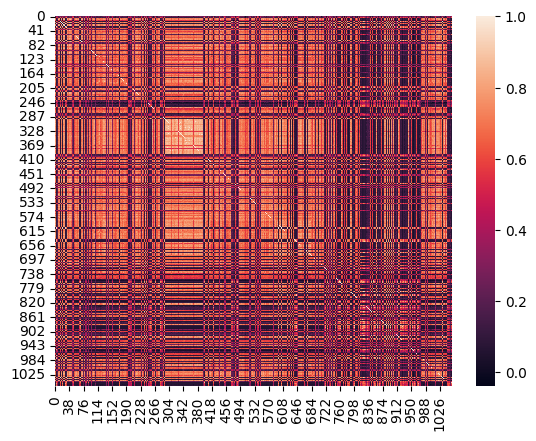

In [15]:
sns.heatmap(cosine_similarity(all_profile_embeddings))

## Diversity of Audience
$$\huge{D = 1 - \frac{\sum s}{N_s}}$$

where
- D = Diversity of Audience (ranges between 0 to 1, higher value -> more diverse audience, lower value -> similar audience)
- s = pairwise similarity score (cosine similarity)
- $N_s$ number of instances

In [16]:
1-sum(sum(cosine_similarity(all_profile_embeddings)))/(1058*1058)

0.5963185520792291

## Applications on

- RahulGandhi
- narendramodi
- elonmusk
- Cristiano
- BillGates

## Weights

In [17]:
alpha = 0.05
rg_w = np.array(exponential_decay_weights(get_timeline_data('RahulGandhi')['created_at'],0.05))
nm_w = np.array(exponential_decay_weights(get_timeline_data('narendramodi')['created_at'],0.05))
em_w = np.array(exponential_decay_weights(get_timeline_data('elonmusk')['created_at'],0.05))
cr_w = np.array(exponential_decay_weights(get_timeline_data('Cristiano')['created_at'],0.05))
bg_w = np.array(exponential_decay_weights(get_timeline_data('BillGates')['created_at'],0.05))

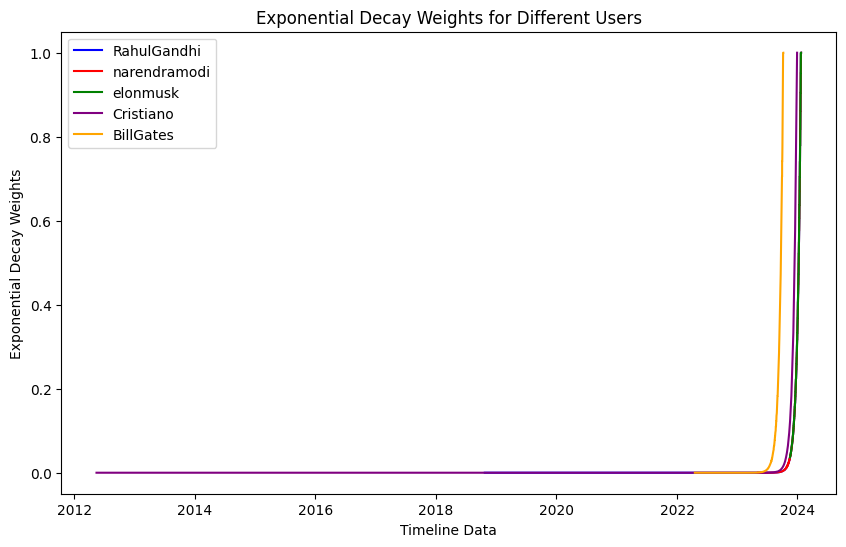

In [18]:
timeline_rg = get_timeline_data('RahulGandhi')['created_at']
timeline_nm = get_timeline_data('narendramodi')['created_at']
timeline_em = get_timeline_data('elonmusk')['created_at']
timeline_cr = get_timeline_data('Cristiano')['created_at']
timeline_bg = get_timeline_data('BillGates')['created_at']

# Plot each user's weights in separate lines with different colors
plt.figure(figsize=(10, 6))
plt.plot(timeline_rg, rg_w, label='RahulGandhi', color='blue')
plt.plot(timeline_nm, nm_w, label='narendramodi', color='red')
plt.plot(timeline_em, em_w, label='elonmusk', color='green')
plt.plot(timeline_cr, cr_w, label='Cristiano', color='purple')
plt.plot(timeline_bg, bg_w, label='BillGates', color='orange')

# Add labels, legend, and title
plt.xlabel('Timeline Data')
plt.ylabel('Exponential Decay Weights')
plt.legend()
plt.title('Exponential Decay Weights for Different Users')

# Show the plot
plt.show()

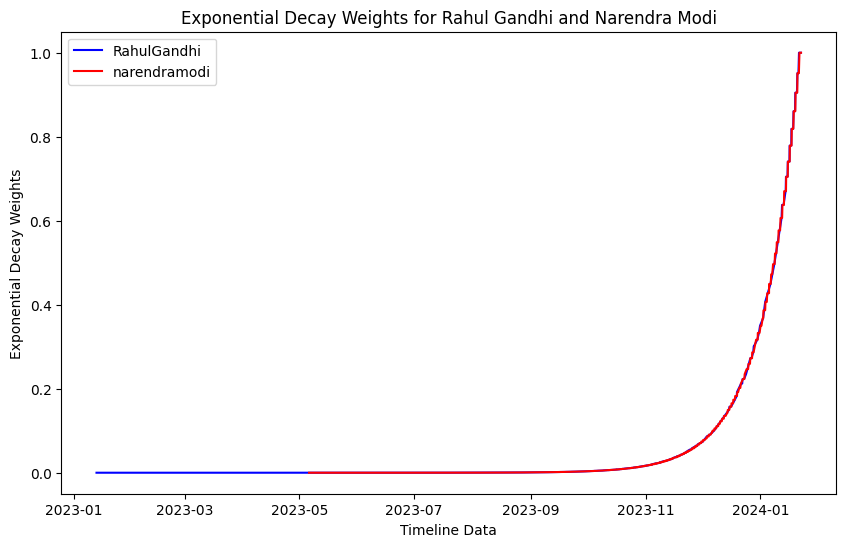

In [19]:
plt.figure(figsize=(10, 6))
plt.plot(timeline_rg[:500], rg_w[:500], label='RahulGandhi', color='blue')
plt.plot(timeline_nm, nm_w, label='narendramodi', color='red')
plt.xlabel('Timeline Data')
plt.ylabel('Exponential Decay Weights')
plt.legend()
plt.title('Exponential Decay Weights for Rahul Gandhi and Narendra Modi')

# Show the plot
plt.show()

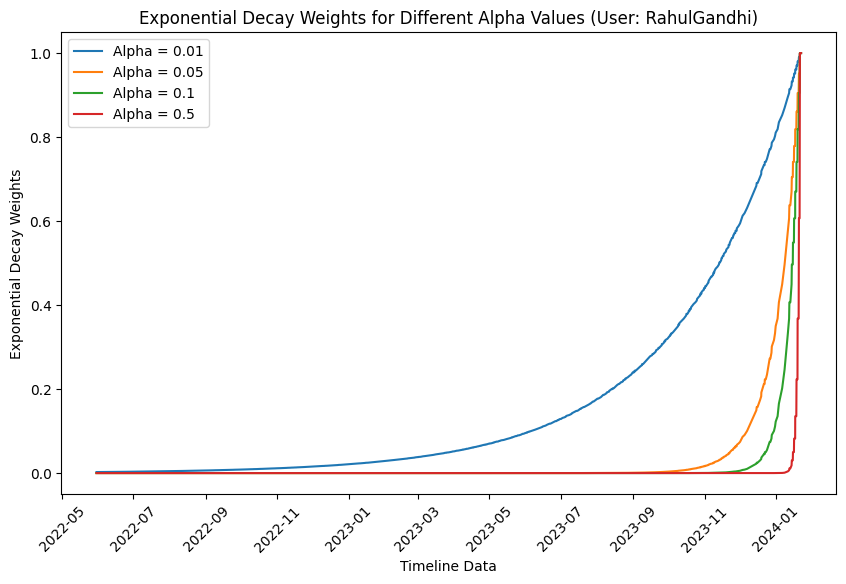

In [20]:
user_timeline = get_timeline_data('RahulGandhi')['created_at'][:1000]

# Different alpha values
alpha_values = [0.01, 0.05, 0.1, 0.5]

# Plot the exponential decay weights for each alpha value
plt.figure(figsize=(10, 6))

for alpha in alpha_values:
    weights = np.array(exponential_decay_weights(user_timeline, alpha))[:1000]
    plt.plot(user_timeline, weights, label=f'Alpha = {alpha}')

# Add labels, legend, and title
plt.xlabel('Timeline Data')
plt.ylabel('Exponential Decay Weights')
plt.legend()
plt.title('Exponential Decay Weights for Different Alpha Values (User: RahulGandhi)')

# Rotate x-axis labels for better visibility (optional)
plt.xticks(rotation=45)

# Show the plot
plt.show()

## Similarity Scores

In [21]:
rg_e = make_profile_embeddings('RahulGandhi')
nm_e = make_profile_embeddings('narendramodi')
em_e = make_profile_embeddings('elonmusk')
cr_e = make_profile_embeddings('Cristiano')
bg_e = make_profile_embeddings('BillGates')

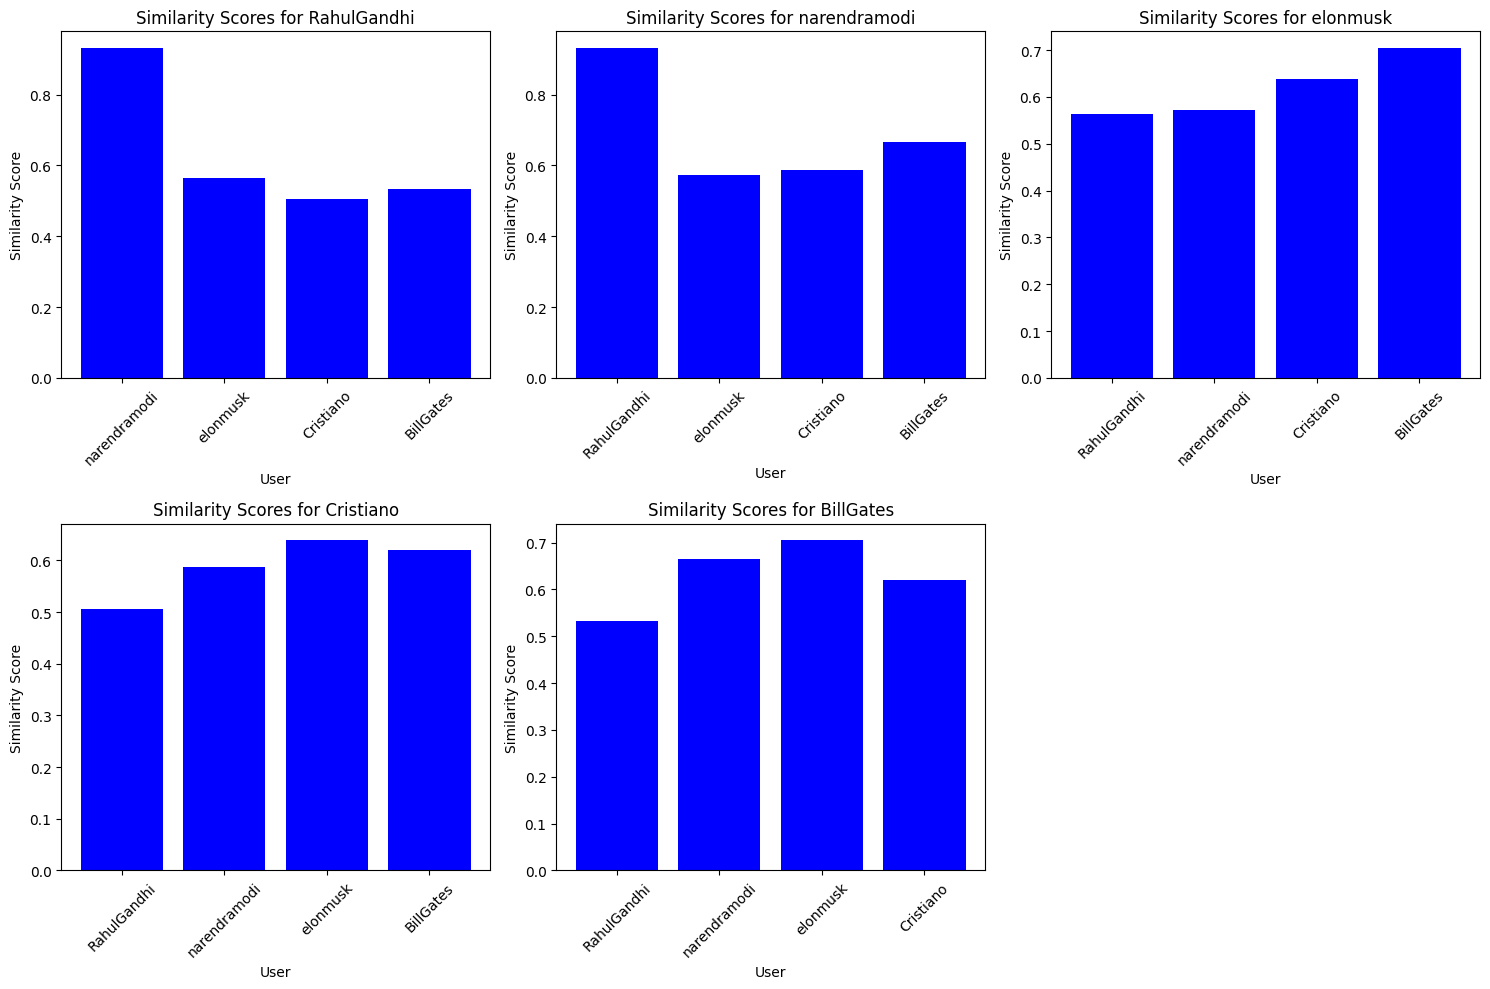

In [22]:
user_embeddings = {
    'RahulGandhi': rg_e,
    'narendramodi': nm_e,
    'elonmusk': em_e,
    'Cristiano': cr_e,
    'BillGates': bg_e
}

# Calculate similarity scores for each user's profile embeddings against all other users
similarities = []

# List of user names
user_names = ['RahulGandhi', 'narendramodi', 'elonmusk', 'Cristiano', 'BillGates']

# Calculate similarities for each user against all other users
for user in user_names:
    user_embedding = user_embeddings[user]
    similarity_scores = []
    
    for other_user in user_names:
        if other_user != user:
            other_user_embedding = user_embeddings[other_user]
            similarity = util.pytorch_cos_sim(user_embedding.reshape(1, -1), other_user_embedding.reshape(1, -1)).item()
            similarity_scores.append(similarity)
    
    similarities.append(similarity_scores)

# Create a separate bar plot for each user
plt.figure(figsize=(15, 10))

for i, user in enumerate(user_names):
    plt.subplot(2, 3, i + 1)
    plt.bar([u for u in user_names if u != user], similarities[i], color='blue')
    plt.title(f'Similarity Scores for {user}')
    plt.xlabel('User')
    plt.ylabel('Similarity Score')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

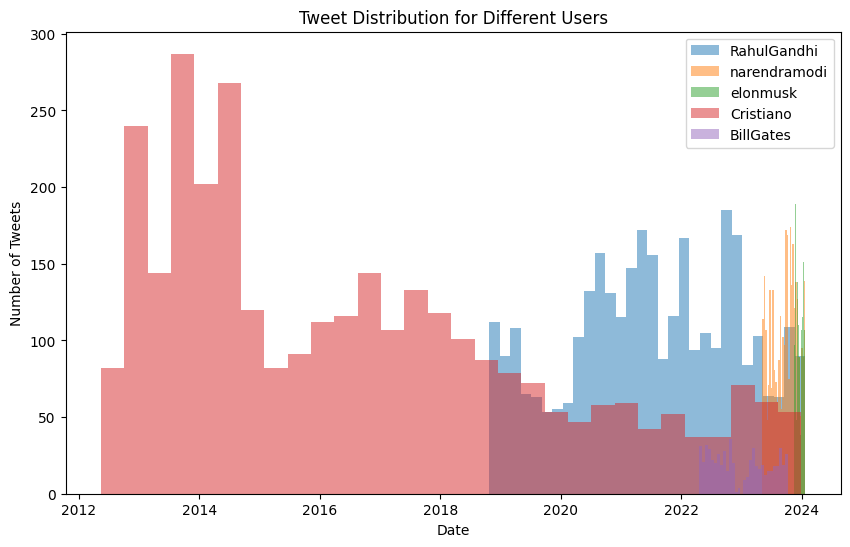

In [23]:
# Example: Distribution of the number of tweets for each user
plt.figure(figsize=(10, 6))
for user in user_names:
    timeline = get_timeline_data(user)['created_at']
    plt.hist(timeline, bins=30, alpha=0.5, label=user)

plt.xlabel('Date')
plt.ylabel('Number of Tweets')
plt.legend()
plt.title('Tweet Distribution for Different Users')
plt.show()


1. Clustering Analysis:
Apply clustering algorithms to group users based on their profile embeddings. K-means clustering or hierarchical clustering can be used. Visualize the clusters to identify patterns and similarities among users.

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


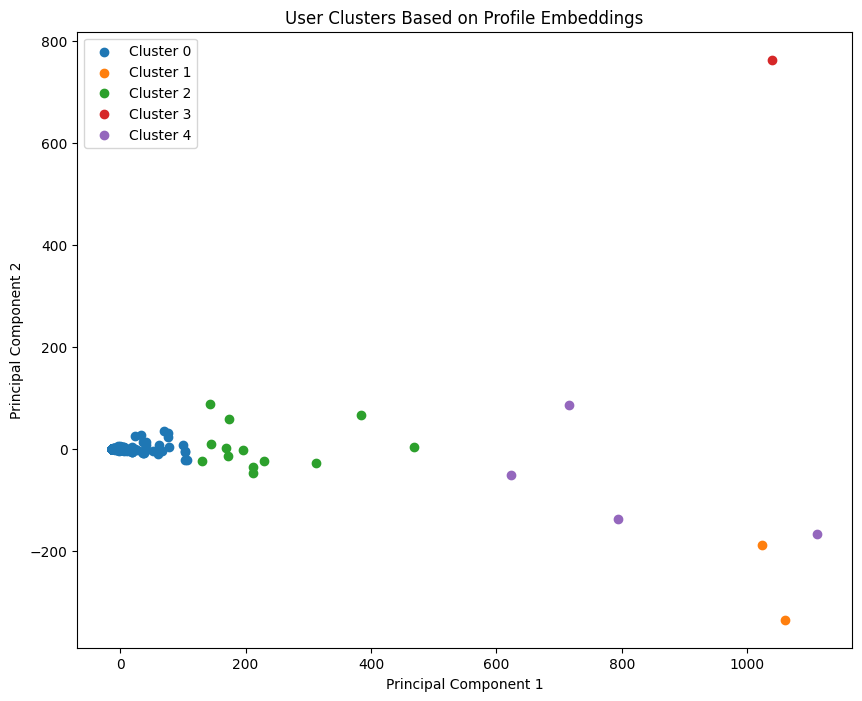

In [24]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Assuming all_profile_embeddings is a 2D array
num_clusters = 5  # Adjust as needed
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(all_profile_embeddings)

# Perform dimensionality reduction for visualization
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(all_profile_embeddings)

# Visualize clusters in 2D space
plt.figure(figsize=(10, 8))
for cluster in range(num_clusters):
    cluster_points = reduced_embeddings[cluster_labels == cluster]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {cluster}')

plt.title('User Clusters Based on Profile Embeddings')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()


Similarity Matrix Heatmap:
Visualize the pairwise cosine similarity scores between user profile embeddings. This can provide an overview of how similar or dissimilar users are to each other.

User Similarity Distribution:
Plot the distribution of cosine similarity scores for a specific user against all other users. This can highlight the diversity or similarity of a particular user compared to the rest.

In [25]:
def user_to_index(user):
    user_data_list = user_data['screen_name'].drop_duplicates().tolist()
    return user_data_list.index(user)
def index_to_user(index):
    user_data_list = user_data['screen_name'].drop_duplicates().tolist()
    return user_data_list[index]

User: afijer_hossain


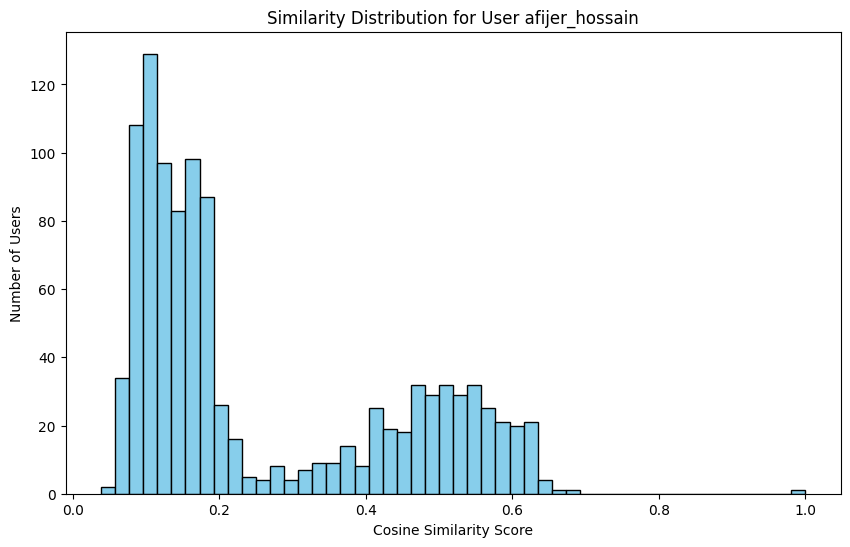

In [26]:
user_index = 2  # Replace with the index of the user you want to analyze
print("User:", index_to_user(user_index))
user_embedding = all_profile_embeddings[user_index]
user_similarity_scores = cosine_similarity(user_embedding.reshape(1, -1), all_profile_embeddings)

plt.figure(figsize=(10, 6))
plt.hist(user_similarity_scores.flatten(), bins=50, color='skyblue', edgecolor='black')
plt.title(f'Similarity Distribution for User {index_to_user(user_index)}')
plt.xlabel('Cosine Similarity Score')
plt.ylabel('Number of Users')
plt.show()


In [27]:
import numpy as np

def find_similar_users(target_user_embedding, embeddings, top_n=5):
    similarities = cosine_similarity(target_user_embedding.reshape(1, -1), embeddings)[0]
    top_indices = np.argsort(similarities)[-top_n:][::-1]
    return top_indices

# Example: Find the top 5 most similar users to the user with index 10
target_user_index = 10
print("User with index 10: ", index_to_user(10))
similar_user_indices = find_similar_users(all_profile_embeddings[target_user_index], all_profile_embeddings)
print("Most similar users to user with index", target_user_index, ":", similar_user_indices)
print("Most similar users to user", index_to_user(10), ":", [index_to_user(i) for i in similar_user_indices])


User with index 10:  ajay_vama88794
Most similar users to user with index 10 : [  10   56  424  399 1047]
Most similar users to user ajay_vama88794 : ['ajay_vama88794', 'MalawatBk', 'Sunilkumar33059', 'Rsingh0771', 'RahulGandhi']


In [28]:
# Example: Find the top 5 most similar users to the user with index 10
target_user_index = 222
print("User with index 222: ", index_to_user(222))
similar_user_indices = find_similar_users(all_profile_embeddings[target_user_index], all_profile_embeddings)
print("Most similar users to user with index", target_user_index, ":", similar_user_indices)
print("Most similar users to user", index_to_user(222), ":", [index_to_user(i) for i in similar_user_indices])

# Get the names of the similar users
# similar_user_names = user_data.loc[similar_user_indices, 'screen_name'].tolist()
# print("Names of similar users:", similar_user_names)


User with index 222:  DaanishKhan1403
Most similar users to user with index 222 : [222 556 441  96   8]
Most similar users to user DaanishKhan1403 : ['DaanishKhan1403', 'DakshSh76953341', 'GazziKhan35539', 'SkKhan972423', 'KhanJunaid84695']


# Multi User-Specific Analysis
Timeline Data and Exponential Decay Weights Graph:

X-axis (Timeline Data): Represents the timeline data of the user, specifically the timestamps of their tweets or Twitter activity.
Y-axis (Weight): Represents the exponential decay weights assigned to each tweet based on its timestamp. Higher weights indicate more recent tweets, and lower weights indicate older tweets.
Interpretation: This graph shows the trend of exponential decay weights over time. Peaks in the graph represent tweets with higher importance (more recent), and valleys represent tweets with lower importance (older). It gives a sense of the user's tweeting activity and the temporal importance assigned to each tweet.

Profile Embedding Graph:

X-axis (Embedding Dimension): Represents the different dimensions of the profile embedding vector.
Y-axis (Embedding Value): Represents the values of the profile embedding in each dimension.
Interpretation: This graph provides insights into the composition of the user's profile embedding. Each bar represents the contribution of a specific dimension to the overall embedding. High bars indicate dimensions with significant contributions, while low bars indicate dimensions with less impact.

These visualizations help you understand the temporal patterns of a user's Twitter activity, the importance assigned to different tweets over time, and the composition of their profile embedding. They are valuable for exploring how users engage on Twitter, the diversity of their content, and the characteristics captured by the profile embedding.

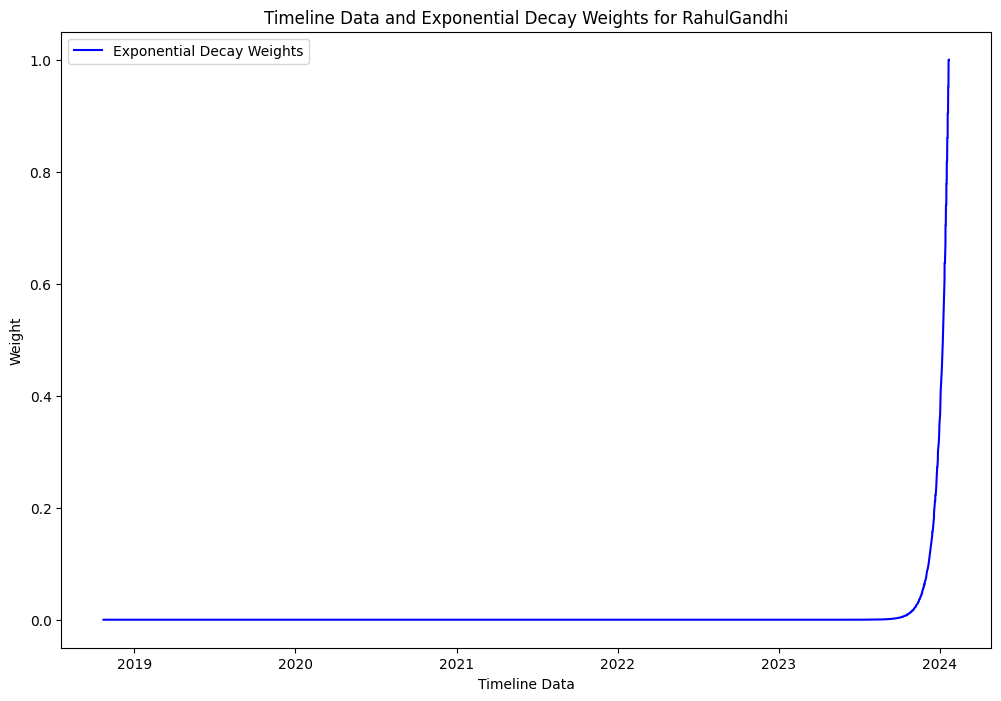

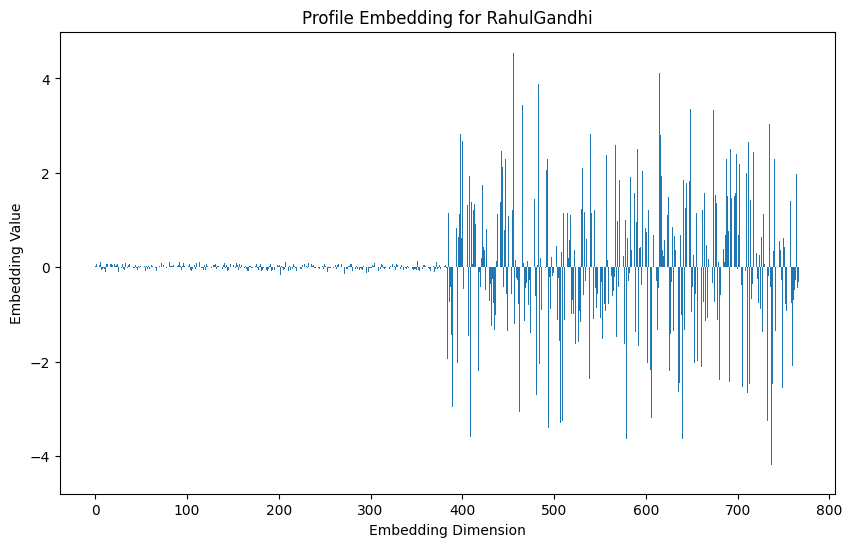

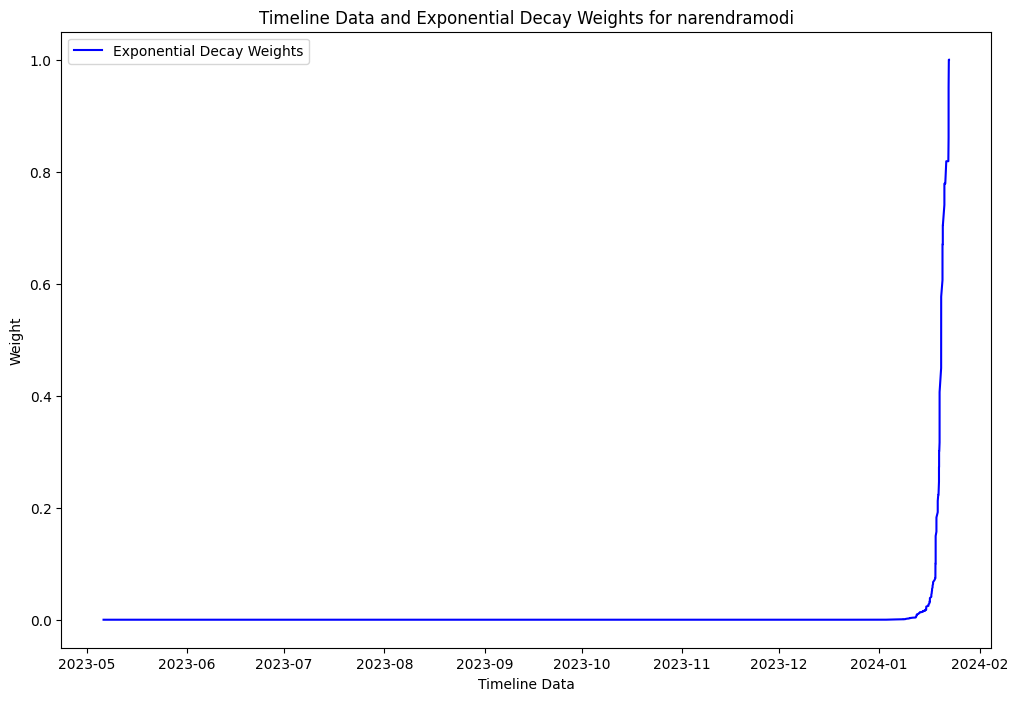

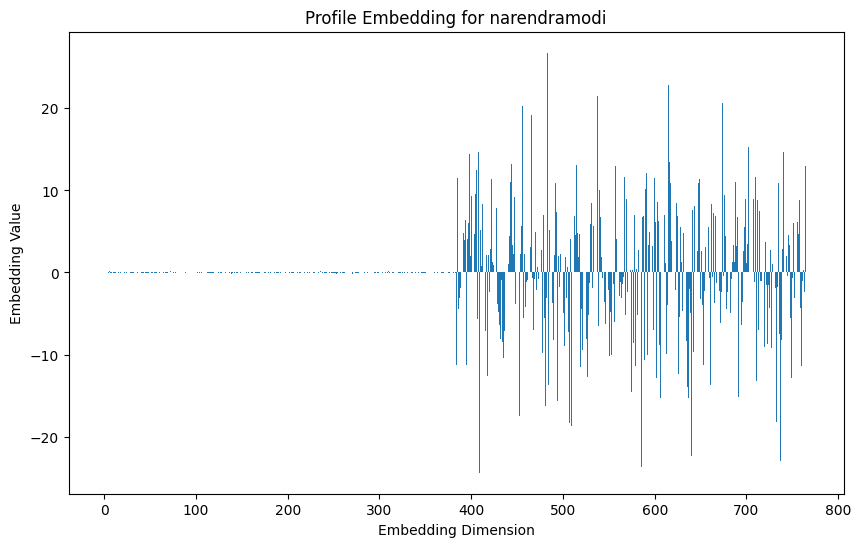

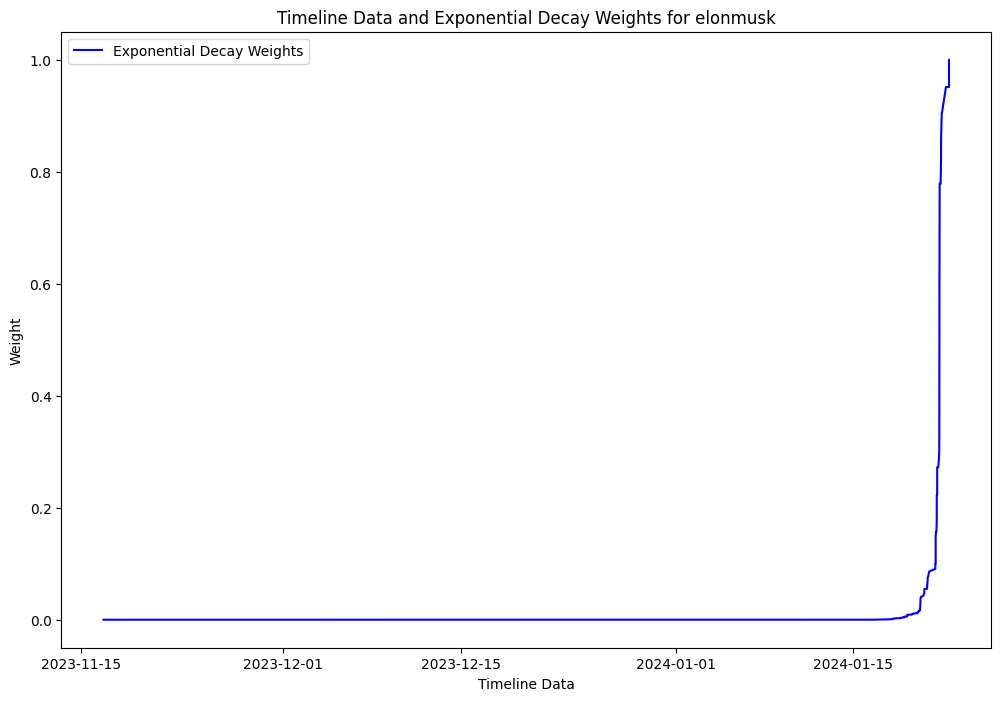

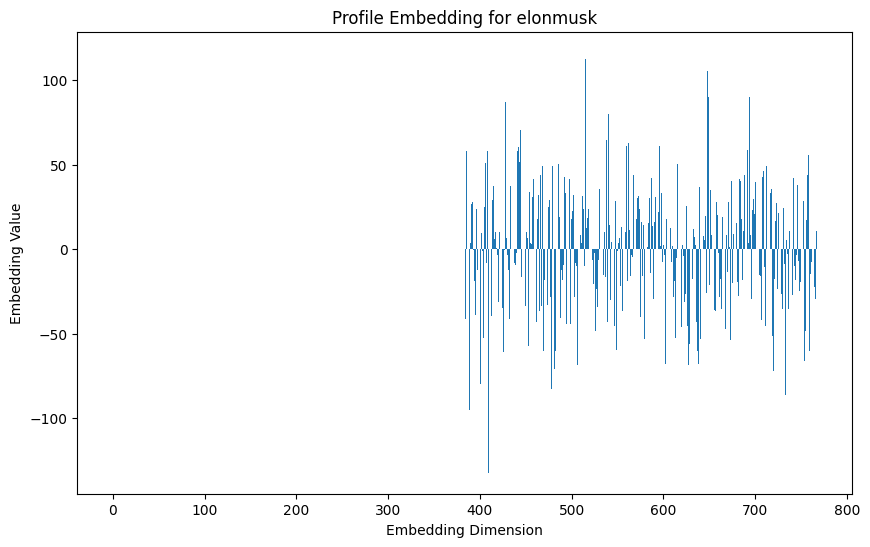

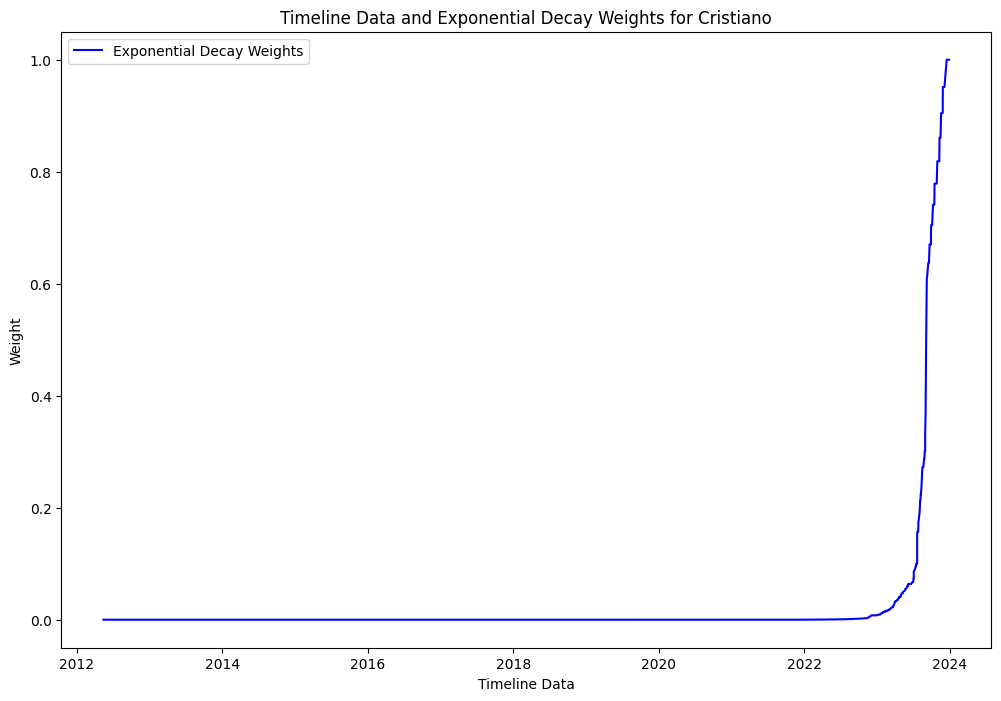

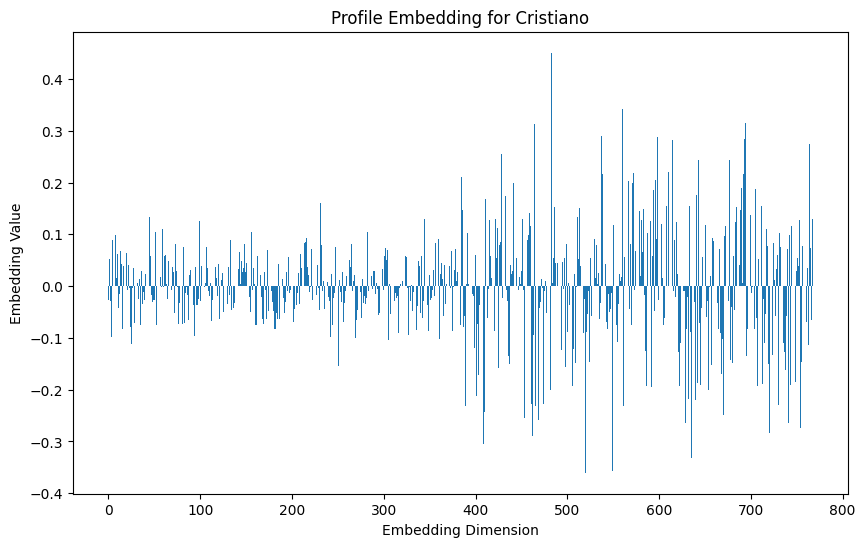

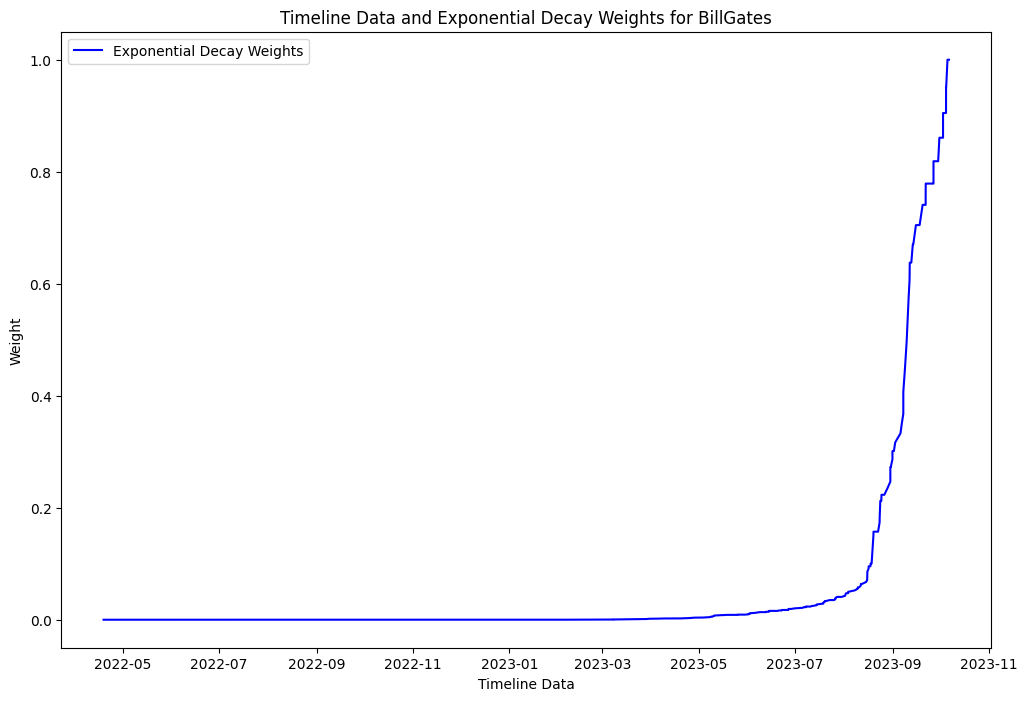

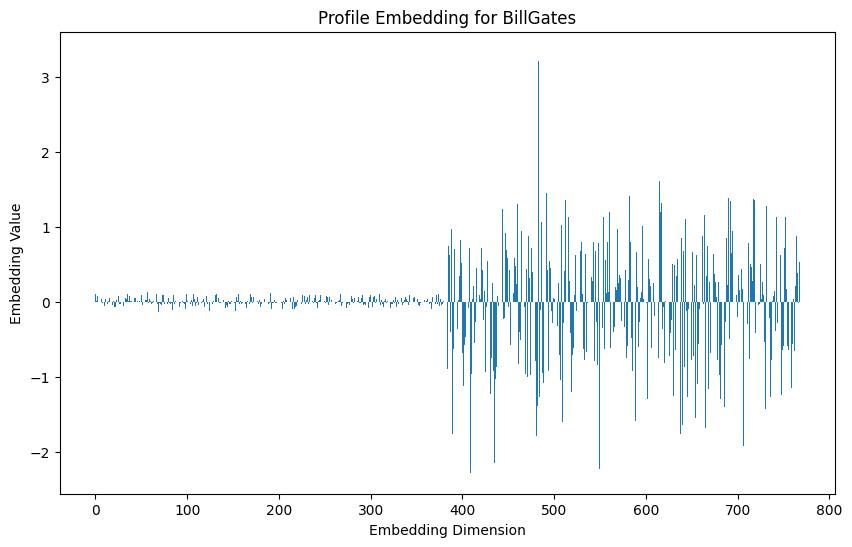

In [29]:
def multi_user_analysis(usernames):
    for username in usernames:
        try:
            # Analyze the timeline data and embeddings for a specific user
            user_timeline_data = get_timeline_data(username)
            user_embedding = make_profile_embeddings(username)

            # Visualize the user's timeline data
            plt.figure(figsize=(12, 8))
            plt.plot(user_timeline_data['created_at'], rg_w[:len(user_timeline_data)], label='Exponential Decay Weights', color='blue')
            plt.title(f'Timeline Data and Exponential Decay Weights for {username}')
            plt.xlabel('Timeline Data')
            plt.ylabel('Weight')
            plt.legend()
            plt.show()

            # Visualize the user's profile embedding
            plt.figure(figsize=(10, 6))
            plt.bar(range(len(user_embedding)), user_embedding)
            plt.title(f'Profile Embedding for {username}')
            plt.xlabel('Embedding Dimension')
            plt.ylabel('Embedding Value')
            plt.show()

        except Exception as e:
            print(f"Error analyzing {username}: {e}")

# Example: Multi-User Analysis
usernames_to_analyze = ['RahulGandhi', 'narendramodi', 'elonmusk', 'Cristiano', 'BillGates']
multi_user_analysis(usernames_to_analyze)


In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

# Example: Content-based recommendation for a user
def content_based_recommendation(username):
    # Get the user's timeline data
    user_timeline_data = get_timeline_data(username)
    
    if len(user_timeline_data) == 0:
        print(f"No timeline data available for {username}. Unable to generate recommendations.")
        return

    # Combine text data (tweets) into a single string
    user_text_data = ' '.join(user_timeline_data['text'])

    # TF-IDF Vectorization
#     vectorizer = TfidfVectorizer(stop_words='english')
#     tfidf_matrix = vectorizer.fit_transform([user_text_data] + user_timeline_data['text'].tolist())
    tweet_embeddings = model.encode([user_text_data]+user_timeline_data['text'].tolist())

    # Calculate cosine similarity between tweets
    cosine_similarities = linear_kernel(tweet_embeddings, tweet_embeddings)

    # Get indices of tweets
    tweet_indices = range(1, len(user_timeline_data) + 1)

    # Function to get tweet recommendations
    def get_recommendations(tweet_index, cosine_similarities, n=5):
        # Get the pairwise similarity scores for the given tweet
        sim_scores = list(enumerate(cosine_similarities[tweet_index]))
        # Sort the tweets based on similarity scores
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        # Get the indices of the top-n similar tweets
        top_indices = [i[0] for i in sim_scores[1:n+1]]
        return top_indices

    # Example: Recommend tweets similar to the first tweet in the timeline
    recommended_tweet_indices = get_recommendations(0, cosine_similarities, n=5)

    # Display the recommended tweets
    print(f"Recommendations for {username}:")
    for index in recommended_tweet_indices:
        print(f"{index}: {user_timeline_data.iloc[index]['text']}")

# Example: Content-based recommendation for a user
content_based_recommendation('RahulGandhi')


Batches:   0%|          | 0/102 [00:00<?, ?it/s]

Recommendations for RahulGandhi:
1: कांग्रेस का कार्यकर्ता बब्बर शेर है, 
किसी से नहीं डरता। 

न नरेंद्र मोदी से, 
न भारत के सबसे भ्रष्ट मुख्यमंत्री से। https://t.co/jYb3jvJ7y3
3056: छत्रपती शिवाजी महाराज हे खऱ्या अर्थाने रयतेचे राजे होते. सर्व समाजातील मावळे एकत्रित करून त्यांनी स्वराज्य उभारलं आ… https://t.co/0HDJ3wOYOA
1028: When publicity drives decisions, you get Policy Bankruptcy. https://t.co/fQKmr8zPzj
252: Call us whatever you want, Mr. Modi. 

We are INDIA. 

We will help heal Manipur and wipe the tears of every woman… https://t.co/n4DAc2cXVO
1260: सिर्फ़ दलित होने के चलते रोहित वेमुला के साथ अत्याचार हुए और उनकी हत्या कर दी गयी।

साल बीत रहे हैं लेकिन वे आज भी… https://t.co/8IGKeu36B5


In [31]:
print(content_based_recommendation('narendramodi'))
print(content_based_recommendation('elonmusk'))
print(content_based_recommendation('BillGates'))


Batches:   0%|          | 0/101 [00:00<?, ?it/s]

Recommendations for narendramodi:
1: सूर्यवंशी भगवान श्री राम के आलोक से विश्व के सभी भक्तगण सदैव ऊर्जा प्राप्त करते हैं।

आज अयोध्या में प्राण-प्रति… https://t.co/jQ3Y62cFdc
23: On Manipur’s Statehood Day, my best wishes to the people of the state. Manipur has made a strong contribution to In… https://t.co/aIns8YikvN
2819: बहुत ही संतोषजनक जानकारी! देशभर में माताओं और शिशुओं के स्वास्थ्य की बेहतर देखभाल के लिए हमारी सरकार ने निरंतर प्र… https://t.co/AbmaVxri9a
2808: Looking forward to inaugurating the National Training Conclave tomorrow, 11th June, at 10:30 AM. Our vision is to b… https://t.co/FIZCncC61q
2509: Leaving for Warangal to attend a programme where we will inaugurate or lay the foundation stone for development wor… https://t.co/EzD3Zy3VLp
None


Batches:   0%|          | 0/101 [00:00<?, ?it/s]

Recommendations for elonmusk:
2: Important https://t.co/kCXopslZ4F
9: @engineers_feed g String Theory
2732: @BillyM2k Thanks Billy!
2781: 🇺🇸🇺🇸 Happy Thanksgiving! 🇺🇸🇺🇸
1550: @Austen @garrytan 🥜
None


Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Recommendations for BillGates:
1: It's great to see all the innovative climate solutions featured this week. https://t.co/iwnit89yLQ
520: Just like we have a robust system to prevent and extinguish fires, there needs to be an equally effective system to… https://t.co/tSmHNCfx0O
341: Progress in health, climate, and education is driven by impatient optimists. Great read by @_HannahRitchie. https://t.co/hgpAYKUEni
506: The brilliant team behind the @_Oceanbird_ could reduce carbon emissions in the sailing industry by up to 90% using… https://t.co/KpZC7OehM8
319: Literally. https://t.co/vorXxKoMlM
None


In [32]:
import random
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

# Example: Cosine similarity-based tweet recommendation
def cosine_similarity_tweet_recommendation(username, num_recommendations=5):
    # Get the user's timeline data
    user_timeline_data = get_timeline_data(username)

    if len(user_timeline_data) == 0:
        print(f"No timeline data available for {username}. Unable to generate recommendations.")
        return

    # Select a random tweet from the user's timeline
    random_tweet_index = random.randint(0, len(user_timeline_data) - 1)
    random_tweet = user_timeline_data.iloc[random_tweet_index]['text']

    # Use TF-IDF vectorization to calculate cosine similarity
    vectorizer = TfidfVectorizer(stop_words='english')
    tfidf_matrix = vectorizer.fit_transform([random_tweet] + user_timeline_data['text'].tolist())
    cosine_similarities = linear_kernel(tfidf_matrix, tfidf_matrix)

    # Get indices of tweets
    tweet_indices = range(1, len(user_timeline_data) + 1)

    # Function to get tweet recommendations based on cosine similarity
    def get_recommendations(tweet_index, cosine_similarities, n=5):
        sim_scores = list(enumerate(cosine_similarities[tweet_index]))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        top_indices = [i[0] for i in sim_scores[1:n+1]]
        return top_indices

    # Get tweet recommendations
    recommended_tweet_indices = get_recommendations(random_tweet_index, cosine_similarities, n=num_recommendations)

    # Display recommended tweets
    print(f"Tweet recommendations based on cosine similarity for {username} (Randomly chosen tweet: '{random_tweet}'):")
    for index in recommended_tweet_indices:
        print(f"{index}: {user_timeline_data.iloc[index]['text']}")

# Example: Recommend 5 tweets based on cosine similarity
cosine_similarity_tweet_recommendation('RahulGandhi', num_recommendations=5)


Tweet recommendations based on cosine similarity for RahulGandhi (Randomly chosen tweet: 'LIVE! Regional Electronic Media Press Conference. https://t.co/Yz65SxSqqC'):
2662: Remembering the brave Judge Loya, who wasn’t transferred.
2806: 🇮🇳Oriya 🇮🇳 Marathi
🇮🇳 Kannada 🇮🇳Hindi 🇮🇳Tamil
🇮🇳English 🇮🇳Gujarati 
🇮🇳Bengali 🇮🇳Urdu 🇮🇳Punjabi 🇮🇳 Konkani 🇮🇳Malayal… https://t.co/B4BejWCw02
2651: रंगों का यह उत्सव आप सब के जीवन को खुशियों के रंग से सराबोर कर दे, सभी देशवासियों को होली की हार्दिक शुभकामनाएं।

H… https://t.co/MbyBylu7sy
2734: आज झारखंड के साहिबगंज जिले के राजमहल विधान सभा क्षेत्र में और गोड्डा जिले  के महागामा विधान सभा क्षेत्र में भाजपा स… https://t.co/Q8t80CGCoS
2711: The attack on Nankana Sahab is reprehensible &amp; must be condemned unequivocally . 

Bigotry is a dangerous, age old… https://t.co/MxJeqf3VPs


In [33]:
cosine_similarity_tweet_recommendation('narendramodi', num_recommendations=5)

Tweet recommendations based on cosine similarity for narendramodi (Randomly chosen tweet: 'Thank you for your warm wishes @VP @KamalaHarris. The success of Chandrayaan-3 is not just a milestone for India bu… https://t.co/ZMnuv8eMrt'):
2051: During our interaction, Siyabulela Xuza spoke at length about his passion for sustainable development and clean ene… https://t.co/kELl18iqZa
2087: India believes in ‘Make in India, Make for the World.’ Over the last few years we have made immense strides in IT,… https://t.co/FuYDgV8aZd
2096: Birthday greetings to Arunachal Pradesh CM Shri Pema Khandu Ji. He is making numerous efforts for the progress of t… https://t.co/XOphQwKbP7
2068: Sharing my remarks at the G20 Trade and Investment Ministers Meeting. @g20org https://t.co/Y6Mub2ms4G
2066: On the occasion of the 15th anniversary of BRICS, we have taken the decision to expand this forum. India has always… https://t.co/4dnDeguWDM
